In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load trained model and scaler
model = load_model("./All_lstm_ddos_model.h5")
scaler = joblib.load("./All_scaler.pkl")

In [ ]:
# Load and select top 20 features
# feature_importance_df = pd.read_csv("top_features.csv")
# top_features = feature_importance_df['Feature'].head(20).tolist()

In [4]:
# Load new dataset for testing
test_df = pd.read_csv("../../Model Training WIthout Sampling/Model_Train.csv") 

In [5]:
# Remove the spaces before the column names
test_df.columns = test_df.columns.str.strip()

## Removing the null values
data2_f=test_df.dropna()

# Replace inf and -inf with NaN in the DataFrame
data2_f = data2_f.replace([float('inf'), float('-inf')], pd.NA)

# Check for NaN values
null_values = data2_f.isnull().sum()

In [6]:
data2_f['Label'] = data2_f['Label'].map({'BENIGN': 0, 'DDoS': 1})

In [8]:

data2_f.fillna(data2_f.mean(), inplace=True)  # Fill numeric NaNs with mean


# Verify that all NaNs are removed
print("Total NaN values after fix:", data2_f.isna().sum().sum())  # Should print 0

C:\Users\LEGION\AppData\Local\Temp\ipykernel_42852\1751523323.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data2_f.fillna(data2_f.mean(), inplace=True)  # Fill numeric NaNs with mean


Total NaN values after fix: 0


In [9]:
# Ensure dataset has the required features
X_test = data2_f.drop('Label', axis=1)
y_test = data2_f["Label"]  # Assuming "Label" column contains ground truth

# Normalize using the previously saved scaler
X_test_scaled = scaler.transform(X_test)

In [10]:

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    y = np.array(y)  # Ensure y is a NumPy array
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])  # Now indexing works properly
    return np.array(Xs), np.array(ys)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps=10)

In [11]:
# Make predictions
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32")

21615/21615 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step


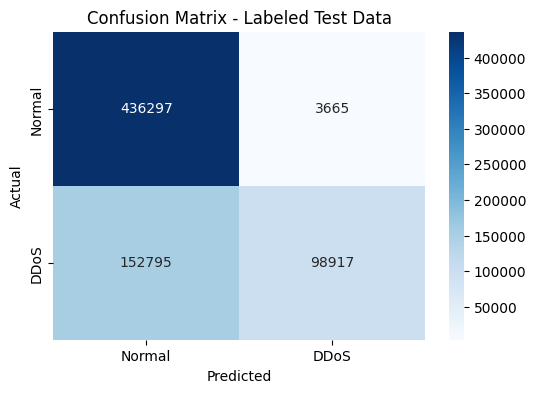

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.99      0.85    439962
           1       0.96      0.39      0.56    251712

    accuracy                           0.77    691674
   macro avg       0.85      0.69      0.70    691674
weighted avg       0.82      0.77      0.74    691674

✅ LSTM Model Accuracy: 77.38%


In [12]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DDoS'], yticklabels=['Normal', 'DDoS'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Labeled Test Data")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test_seq, y_pred))

accuracy = accuracy_score(y_test_seq, y_pred)
print(f"✅ LSTM Model Accuracy: {accuracy * 100:.2f}%")